In [14]:
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.models import * 
from tensorflow.keras.preprocessing import image
from tensorflow import keras
from keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

In [15]:
import glob,os,cv2
hand_negative=glob.glob('/kaggle/input/mura-final/finaldata/train_final/XR_SHOULDER/negative/*.png')
hand_positive=glob.glob('/kaggle/input/mura-final/finaldata/train_final/XR_SHOULDER/positive/*.png')

hand_negative_t=glob.glob('/kaggle/input/mura-final/finaldata/valid_final/XR_SHOULDER/negative/*.png')
hand_positive_t=glob.glob('/kaggle/input/mura-final/finaldata/valid_final/XR_SHOULDER/positive/*.png')

In [16]:
data=[]
label=[]
ii=0
for i in hand_negative:
    while(ii<1500):
        a=cv2.imread(i,0)
        a=cv2.resize(a,(224,224))
        data.append(a)
        label.append(0)
        ii=ii+1
for i in hand_positive:
    a=cv2.imread(i,0)
    a=cv2.resize(a,(224,224))
    data.append(a)
    label.append(1)
for i in hand_negative_t:
        a=cv2.imread(i,0)
        a=cv2.resize(a,(224,224))
        data.append(a)
        label.append(0)
for i in hand_positive_t:
    a=cv2.imread(i,0)
    a=cv2.resize(a,(224,224))
    data.append(a)
    label.append(1)

In [17]:
data=np.array(data)
label=np.array(label)

In [18]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(data,label,stratify=label,test_size=0.2)

In [19]:
# Building the Xception Model Architecture

def entry_flow(inputs):

    x = layers.Conv2D(32, 3, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    previous_block_activation = x  # Set aside residual
    
    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for size in [128, 256, 728]:
        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(size, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(size, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

        residual = layers.Conv2D(  # Project residual
            size, 1, strides=2, padding='same')(previous_block_activation)           
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    return x

def middle_flow(x, num_blocks=8):
  
    previous_block_activation = x

    for _ in range(num_blocks):
        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(728, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(728, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(728, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.add([x, previous_block_activation])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    return x


def exit_flow(x, num_classes=2):
  
    previous_block_activation = x

    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(728, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(1024, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    residual = layers.Conv2D(  # Project residual
      1024, 1, strides=2, padding='same')(previous_block_activation)
    x = layers.add([x, residual])  # Add back residual

    x = layers.SeparableConv2D(1536, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.SeparableConv2D(2048, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 1:
        activation = 'sigmoid'
    else:
        activation = 'softmax'
    return layers.Dense(num_classes, activation=activation)(x)

In [20]:
# Building the Xception Model Architecture

inputs = keras.Input(shape=(224, 224, 1))
outputs = exit_flow(middle_flow(entry_flow(inputs)))
model = keras.Model(inputs, outputs)

# Compiling the Model
model.compile(optimizer='adam', loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

# Checking Model Summary
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 112, 112,  │        320 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        128 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_36       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 112, 112,  │     18,496 │ activation_36[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_37       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_38       │ (None, 112, 112,  │          0 │ activation_37[0]… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_34 │ (None, 112, 112,  │      8,896 │ activation_38[0]… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_39       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_35 │ (None, 112, 112,  │     17,664 │ activation_39[0]… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 56, 56,    │      8,320 │ activation_37[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 56, 56,    │          0 │ max_pooling2d_4[… │
│                     │ 128)              │            │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_40       │ (None, 56, 56,    │          0 │ add_12[0][0]    

 Total params: 20,883,722 (79.67 MB)

 Trainable params: 20,833,466 (79.47 MB)

 Non-trainable params: 50,256 (196.31 KB)

In [21]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 'precision', 'recall', 'auc'])


In [22]:
from keras.utils import to_categorical

# Convert the target data to binary labels
y_train_binary = to_categorical(y_train, num_classes=2)
y_test_binary = to_categorical(y_test, num_classes=2)

# Train the model using the binary labels
history = model.fit(
    x_train, y_train_binary,
    epochs=20,
    validation_data=(x_test, y_test_binary)
)


Epoch 1/20


W0000 00:00:1713109283.962267      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - AUC: 0.9509 - Precision: 0.9482 - Recall: 0.9482 - accuracy: 0.9482 - loss: 0.2203

W0000 00:00:1713109346.283587      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713109349.930652      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


156/156 ━━━━━━━━━━━━━━━━━━━━ 114s 450ms/step - AUC: 0.9509 - Precision: 0.9482 - Recall: 0.9482 - accuracy: 0.9482 - loss: 0.2201 - val_AUC: 0.7128 - val_Precision: 0.7137 - val_Recall: 0.7137 - val_accuracy: 0.7137 - val_loss: 0.6010
Epoch 2/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 42s 268ms/step - AUC: 0.9621 - Precision: 0.9607 - Recall: 0.9607 - accuracy: 0.9607 - loss: 0.1595 - val_AUC: 0.6286 - val_Precision: 0.7137 - val_Recall: 0.7137 - val_accuracy: 0.7137 - val_loss: 0.7179
Epoch 3/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 82s 268ms/step - AUC: 0.9594 - Precision: 0.9486 - Recall: 0.9486 - accuracy: 0.9486 - loss: 0.1899 - val_AUC: 0.8147 - val_Precision: 0.7137 - val_Recall: 0.7137 - val_accuracy: 0.7137 - val_loss: 0.7255
Epoch 4/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 42s 268ms/step - AUC: 0.9616 - Precision: 0.9576 - Recall: 0.9576 - accuracy: 0.9576 - loss: 0.1676 - val_AUC: 0.9635 - val_Precision: 0.9391 - val_Recall: 0.9391 - val_accuracy: 0.9391 - val_loss: 0.2626
Epoch 5/20
156/156 ━━━━━━━━━━━

In [28]:
from tensorflow.keras.models import save_model

# Assuming you have your trained model in the variable 'model'

# Save the entire model (architecture, weights, and training configuration)
save_model(model, 'shoulder_model.h5')  # Replace with your desired filename


In [29]:
# Convert the target data to binary labels
y_train_binary = to_categorical(y_train, num_classes=2)

# Evaluate the model using the binary labels
model.evaluate(x_train, y_train_binary)


156/156 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step - AUC: 0.9253 - Precision: 0.8364 - Recall: 0.8364 - accuracy: 0.8364 - loss: 0.3405


W0000 00:00:1713110515.265080      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


[0.3451096713542938,
 0.9241583347320557,
 0.836476743221283,
 0.836476743221283,
 0.836476743221283]

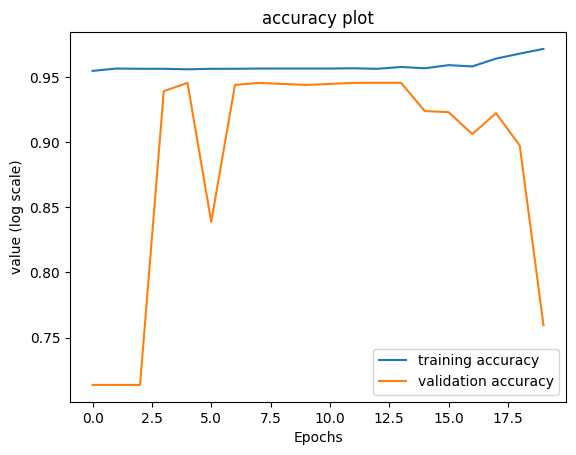

In [26]:
import matplotlib.pyplot as plt
plt.title('accuracy plot')
plt.plot(history.history['accuracy'],label='training accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("value (log scale)")
plt.legend();

In [30]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 'precision', 'recall', 'auc'])


KeyError: 'precision'

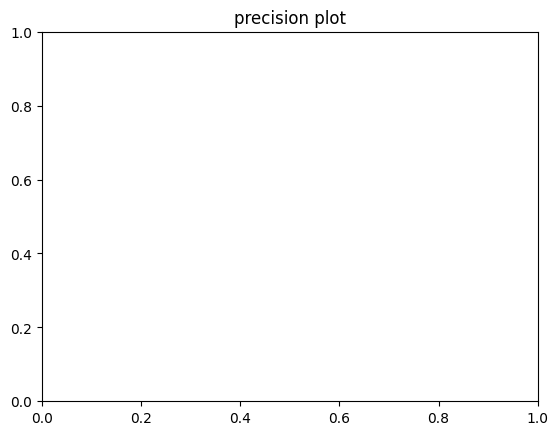

In [31]:
plt.title('precision plot')
plt.plot(history.history['precision'],label='training precision')
plt.plot(history.history['val_precision'],label='validation precision')
plt.xlabel("Epochs")
plt.ylabel("value (log scale)")
plt.legend();

KeyError: 'recall'

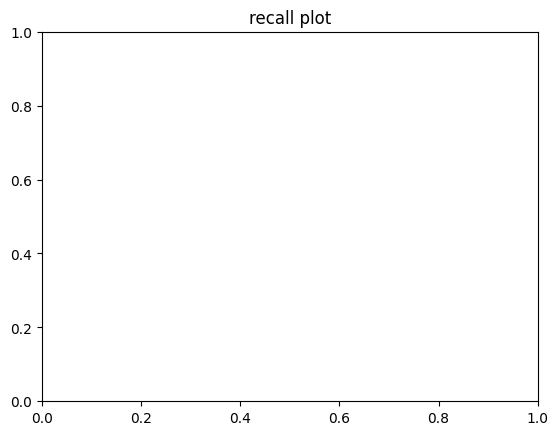

In [32]:
plt.title('recall plot')
plt.plot(history.history['recall'],label='training recall')
plt.plot(history.history['val_recall'],label='validation recall')
plt.xlabel("Epochs")
plt.ylabel("value (log scale)")
plt.legend();

KeyError: 'auc'

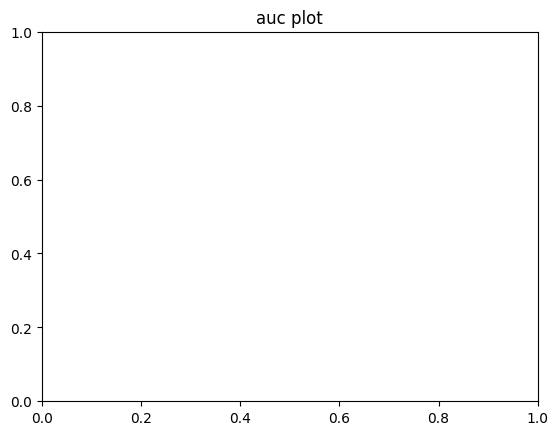

In [33]:
plt.title('auc plot')
plt.plot(history.history['auc'],label='training auc')
plt.plot(history.history['val_auc'],label='validation auc')
plt.xlabel("Epochs")
plt.ylabel("value (log scale)")
plt.legend();

In [34]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
train=model.predict(x_train)
val=model.predict(x_test)

  4/156 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step

W0000 00:00:1713110674.992339      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


156/156 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step


W0000 00:00:1713110687.252262      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step


In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Convert probabilities to binary predictions
train_predictions = (train >= 0.5).astype(int)

# Calculate the confusion matrix
conf_matrix_train = confusion_matrix(y_train, train_predictions)

# Plot the confusion matrix
sns.heatmap(conf_matrix_train, annot=True)


ValueError: Classification metrics can't handle a mix of binary and multilabel-indicator targets

In [37]:
sns.heatmap(confusion_matrix(val,y_test),annot=True)

ValueError: Classification metrics can't handle a mix of multilabel-indicator and binary targets

In [ ]:
print(classification_report(train,y_train))

In [ ]:
print(classification_report(val,y_test))